Found 900 files belonging to 6 classes.
Using 720 files for training.
Found 900 files belonging to 6 classes.
Using 180 files for validation.
Epoch 1/20
23/23 [==============================] - 19s 484ms/step - loss: 4.2015 - accuracy: 0.3403 - val_loss: 3.5935 - val_accuracy: 0.5611


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
23/23 [==============================] - 9s 395ms/step - loss: 3.1460 - accuracy: 0.7014 - val_loss: 3.2158 - val_accuracy: 0.7722
Epoch 3/20
23/23 [==============================] - 9s 405ms/step - loss: 2.8315 - accuracy: 0.8139 - val_loss: 3.0014 - val_accuracy: 0.8111
Epoch 4/20
23/23 [==============================] - 9s 391ms/step - loss: 2.6904 - accuracy: 0.8458 - val_loss: 2.8496 - val_accuracy: 0.8389
Epoch 5/20
23/23 [==============================] - 9s 399ms/step - loss: 2.5319 - accuracy: 0.9194 - val_loss: 2.7333 - val_accuracy: 0.8667
Epoch 6/20
23/23 [==============================] - 9s 400ms/step - loss: 2.4816 - accuracy: 0.9292 - val_loss: 2.6403 - val_accuracy: 0.8944
Epoch 7/20
23/23 [==============================] - 9s 397ms/step - loss: 2.4060 - accuracy: 0.9417 - val_loss: 2.5730 - val_accuracy: 0.9056
Epoch 8/20
23/23 [==============================] - 9s 382ms/step - loss: 2.3529 - accuracy: 0.9639 - val_loss: 2.5112 - val_accuracy: 0.9000
Epoch 

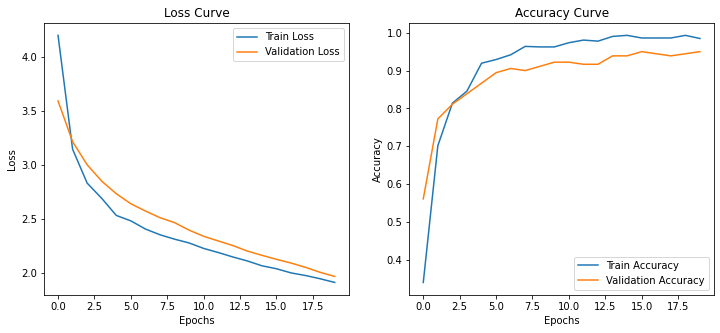

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pandas as pd

# ===== 데이터 경로 설정 =====
image_data = 'Train_Test_Valid/Train/'
image_valid_data = 'Train_Test_Valid/Valid/'

# ===== 학습 데이터 로드 =====
batch_size = 32
target_size = (224, 224)

train = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=0.2,  # 학습 데이터의 20%를 검증으로 분리
    subset="training",
    seed=123,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=0.2,  # 동일한 분할 비율
    subset="validation",
    seed=123,
    image_size=target_size,
    batch_size=batch_size,
)

# 데이터셋 Prefetch 최적화
AUTOTUNE = tf.data.AUTOTUNE
train = train.prefetch(buffer_size=AUTOTUNE)
validation = validation.prefetch(buffer_size=AUTOTUNE)

# ===== 데이터 증강 (Data Augmentation) =====
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
])

# 데이터 증강을 학습 데이터셋에 적용
train = train.map(lambda x, y: (data_augmentation(x, training=True), y))

# ===== Fine-tuning =====
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 특정 레이어까지만 고정
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# ===== 모델 구성 =====
keras_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

# ===== 모델 컴파일 =====
custom_adam = Adam(learning_rate=1e-4)
keras_model.compile(
    optimizer=custom_adam,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ===== 학습 콜백 =====
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_with_gap_reduction.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# ===== 모델 훈련 =====
history = keras_model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[checkpoint, early_stopping]
)

# ===== 성능 시각화 =====
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
